# 00. Import

In [1]:
import random
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, cross_val_score
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

DATA_PATH = "./csv_files/"
SEED = 42

# 01. 데이터 확인

## load data

In [2]:
train_df = pd.read_csv(f'{DATA_PATH}train.csv')
building_info = pd.read_csv(f'{DATA_PATH}building_info.csv')
test_df = pd.read_csv(f'{DATA_PATH}test.csv')

In [3]:
train_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


## replace '-' to 'nan'

In [4]:
train_df.replace('-', np.nan, inplace=True)
building_info.replace('-', np.nan, inplace=True)
test_df.replace('-', np.nan, inplace=True)

## csv info

### 1) train.csv

In [5]:
train_df.describe()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
count,204000.000000,204000.000000,43931.000000,203981.000000,203991.000000,128818.000000,116087.000000,204000.000000
mean,50.500000,25.543524,2.040830,2.134031,78.716295,0.333637,1.063823,2451.036462
std,28.866141,3.779523,5.165218,1.358109,15.080108,0.401486,1.001030,2440.648858
min,1.000000,10.100000,0.000000,0.000000,13.000000,0.000000,0.000000,0.000000
25%,25.750000,23.400000,0.000000,1.200000,69.000000,0.000000,0.200000,1085.760000
50%,50.500000,25.700000,0.100000,2.000000,81.000000,0.100000,0.710000,1766.400000
75%,75.250000,28.100000,1.300000,2.800000,91.000000,0.700000,1.780000,2970.000000
max,100.000000,37.100000,92.200000,13.300000,100.000000,1.000000,3.920000,25488.400000


In [6]:
train_df.shape

(204000, 10)

In [7]:
train_df.head(10)

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40
5,1_20220601 05,1,20220601 05,17.2,NaN,2.1,46.0,NaN,NaN,1087.20
6,1_20220601 06,1,20220601 06,16.3,NaN,1.0,50.0,0.0,0.05,1314.72
7,1_20220601 07,1,20220601 07,17.4,NaN,1.3,50.0,1.0,0.55,1684.80
8,1_20220601 08,1,20220601 08,20.6,NaN,1.8,44.0,1.0,1.29,1976.16
9,1_20220601 09,1,20220601 09,23.2,NaN,1.7,41.0,1.0,2.01,2289.12


In [8]:
train_df.isna().sum()

num_date_time         0
건물번호                  0
일시                    0
기온(C)                 0
강수량(mm)          160069
풍속(m/s)              19
습도(%)                 9
일조(hr)            75182
일사(MJ/m2)         87913
전력소비량(kWh)            0
dtype: int64

### 2) building_info.csv

In [9]:
building_info.describe()

,건물번호,연면적(m2),냉방면적(m2)
count,100.000000,1.000000e+02,1.000000e+02
mean,50.500000,2.608875e+05,1.864032e+05
std,29.011492,1.279963e+06,1.090638e+06
min,1.000000,5.578400e+03,0.000000e+00
25%,25.750000,6.144612e+04,2.318700e+04
50%,50.500000,9.264050e+04,5.582336e+04
75%,75.250000,1.848135e+05,9.915097e+04
max,100.000000,1.287288e+07,1.094194e+07


In [10]:
building_info.shape

(100, 7)

In [11]:
building_info.head(10)

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,NaN,NaN,NaN
1,2,건물기타,122233.47,99000.00,NaN,NaN,NaN
2,3,건물기타,171243.00,113950.00,40,NaN,NaN
3,4,건물기타,74312.98,34419.62,60,NaN,NaN
4,5,건물기타,205884.00,150000.00,NaN,2557,1000
5,6,건물기타,205754.00,74565.00,NaN,NaN,NaN
6,7,건물기타,101711.52,41341.10,NaN,800,300
7,8,건물기타,75344.54,24117.00,NaN,NaN,NaN
8,9,건물기타,222882.35,15651.18,NaN,NaN,NaN
9,10,건물기타,31062.00,18637.00,NaN,NaN,NaN


In [12]:
building_info.isna().sum()

건물번호             0
건물유형             0
연면적(m2)          0
냉방면적(m2)         0
태양광용량(kW)       64
ESS저장용량(kWh)    95
PCS용량(kW)       95
dtype: int64

### 3) test.csv

In [13]:
test_df.describe()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%)
count,16800.000000,16800.000000,16800.000000,16800.000000,16800.000000
mean,50.500000,21.975232,0.266720,1.783405,77.148036
std,28.866929,2.884010,1.130288,1.041896,16.080725
min,1.000000,12.200000,0.000000,0.000000,26.000000
25%,25.750000,19.900000,0.000000,1.000000,66.750000
50%,50.500000,21.700000,0.000000,1.700000,79.000000
75%,75.250000,23.600000,0.000000,2.500000,90.000000
max,100.000000,32.300000,18.800000,7.000000,100.000000


In [14]:
test_df.shape

(16800, 7)

In [15]:
test_df.head(10)

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77
5,1_20220825 05,1,20220825 05,21.6,0.0,1.6,81
6,1_20220825 06,1,20220825 06,21.5,0.0,2.3,84
7,1_20220825 07,1,20220825 07,21.7,0.0,1.4,83
8,1_20220825 08,1,20220825 08,22.3,0.0,2.2,82
9,1_20220825 09,1,20220825 09,22.7,0.0,2.4,78


In [16]:
test_df.isna().sum()

num_date_time    0
건물번호             0
일시               0
기온(C)            0
강수량(mm)          0
풍속(m/s)          0
습도(%)            0
dtype: int64

## drop 'num_date_time': 건물번호 + 일시 (굳이 필요없음)

In [17]:
train_df.drop('num_date_time', axis = 1, inplace=True)
test_df.drop('num_date_time', axis = 1, inplace=True)

## Column Name : rename 한글 to 영어

In [18]:
train_df = train_df.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})

In [19]:
building_info = building_info.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

In [20]:
test_df = test_df.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})

## 범주형 인코딩

In [21]:
translation_dict = dict(zip(list(building_info['building_type'].unique()), [0,1,2,3,4,5,6,7,8,9,10,11]))
translation_dict

{'건물기타': 0,
 '공공': 1,
 '대학교': 2,
 '데이터센터': 3,
 '백화점및아울렛': 4,
 '병원': 5,
 '상용': 6,
 '아파트': 7,
 '연구소': 8,
 '지식산업센터': 9,
 '할인마트': 10,
 '호텔및리조트': 11}

In [22]:
building_info.head()

,building_number,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,건물기타,110634.00,39570.00,NaN,NaN,NaN
1,2,건물기타,122233.47,99000.00,NaN,NaN,NaN
2,3,건물기타,171243.00,113950.00,40,NaN,NaN
3,4,건물기타,74312.98,34419.62,60,NaN,NaN
4,5,건물기타,205884.00,150000.00,NaN,2557,1000


## building_info 합치기

In [23]:
train_ft = train_df.merge(building_info, how='left',on='building_number')
test_ft = test_df.merge(building_info, how='left',on='building_number')

In [24]:
train_ft['building_type'] = train_ft['building_type'].map(translation_dict)
test_ft['building_type'] = test_ft['building_type'].map(translation_dict)

## train_ft & test_ft 확인

In [25]:
train_ft.head()

,building_number,date_time,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28,0,110634.0,39570.0,NaN,NaN,NaN
1,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36,0,110634.0,39570.0,NaN,NaN,NaN
2,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88,0,110634.0,39570.0,NaN,NaN,NaN
3,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76,0,110634.0,39570.0,NaN,NaN,NaN
4,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40,0,110634.0,39570.0,NaN,NaN,NaN


In [26]:
test_ft.head()

,building_number,date_time,temperature,rainfall,windspeed,humidity,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,20220825 00,23.5,0.0,2.2,72,0,110634.0,39570.0,NaN,NaN,NaN
1,1,20220825 01,23.0,0.0,0.9,72,0,110634.0,39570.0,NaN,NaN,NaN
2,1,20220825 02,22.7,0.0,1.5,75,0,110634.0,39570.0,NaN,NaN,NaN
3,1,20220825 03,22.1,0.0,1.3,78,0,110634.0,39570.0,NaN,NaN,NaN
4,1,20220825 04,21.8,0.0,1.0,77,0,110634.0,39570.0,NaN,NaN,NaN


## target 생성

In [27]:
target = train_ft['power_consumption']
target

0         1085.28
1         1047.36
2          974.88
3          953.76
4          986.40
           ...   
203995     881.04
203996     798.96
203997     825.12
203998     640.08
203999     540.24
Name: power_consumption, Length: 204000, dtype: float64

## 결측치 확인

In [28]:
len(train_ft)

204000

In [29]:
train_ft.isna().sum()

building_number              0
date_time                    0
temperature                  0
rainfall                160069
windspeed                   19
humidity                     9
sunshine                 75182
solar_radiation          87913
power_consumption            0
building_type                0
total_area                   0
cooling_area                 0
solar_power_capacity    130560
ess_capacity            193800
pcs_capacity            193800
dtype: int64

In [30]:
len(test_ft)

16800

In [31]:
test_ft.isna().sum()

building_number             0
date_time                   0
temperature                 0
rainfall                    0
windspeed                   0
humidity                    0
building_type               0
total_area                  0
cooling_area                0
solar_power_capacity    10752
ess_capacity            15960
pcs_capacity            15960
dtype: int64

## sunshine, solar_radiation, solar_power_capacity, ess_capacity, pcs_capacity 제거 : 결측치 채우기 불가

In [32]:
if train_ft is None:
    print("train_ft is None")
else:
    print("train_ft is not None")

train_ft is not None


In [33]:
train_ft = train_ft.drop(['sunshine', 'solar_radiation', 'solar_power_capacity', 'ess_capacity', 'pcs_capacity'], axis=1)
test_ft = test_ft.drop(['solar_power_capacity', 'ess_capacity', 'pcs_capacity'], axis=1)

In [34]:
train_ft.head()

,building_number,date_time,temperature,rainfall,windspeed,humidity,power_consumption,building_type,total_area,cooling_area
0,1,20220601 00,18.6,NaN,0.9,42.0,1085.28,0,110634.0,39570.0
1,1,20220601 01,18.0,NaN,1.1,45.0,1047.36,0,110634.0,39570.0
2,1,20220601 02,17.7,NaN,1.5,45.0,974.88,0,110634.0,39570.0
3,1,20220601 03,16.7,NaN,1.4,48.0,953.76,0,110634.0,39570.0
4,1,20220601 04,18.4,NaN,2.8,43.0,986.40,0,110634.0,39570.0


In [35]:
train_ft.isna().sum()

building_number           0
date_time                 0
temperature               0
rainfall             160069
windspeed                19
humidity                  9
power_consumption         0
building_type             0
total_area                0
cooling_area              0
dtype: int64

In [36]:
test_ft.head()

,building_number,date_time,temperature,rainfall,windspeed,humidity,building_type,total_area,cooling_area
0,1,20220825 00,23.5,0.0,2.2,72,0,110634.0,39570.0
1,1,20220825 01,23.0,0.0,0.9,72,0,110634.0,39570.0
2,1,20220825 02,22.7,0.0,1.5,75,0,110634.0,39570.0
3,1,20220825 03,22.1,0.0,1.3,78,0,110634.0,39570.0
4,1,20220825 04,21.8,0.0,1.0,77,0,110634.0,39570.0


In [37]:
test_ft.isna().sum()

building_number    0
date_time          0
temperature        0
rainfall           0
windspeed          0
humidity           0
building_type      0
total_area         0
cooling_area       0
dtype: int64

## 결측치가 있는 column과 power_consumption의 관계

### 1) rainfall

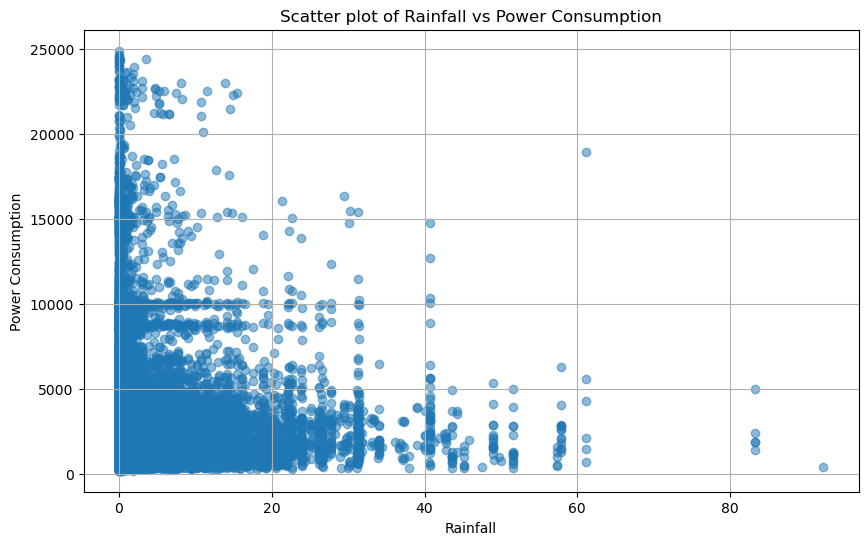

In [38]:
# 결측치가 있는 rainfall 값 필터링
rainfall_notna = train_ft[train_ft['rainfall'].notna()]

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.scatter(rainfall_notna['rainfall'], rainfall_notna['power_consumption'], alpha=0.5)
plt.title('Scatter plot of Rainfall vs Power Consumption')
plt.xlabel('Rainfall')
plt.ylabel('Power Consumption')
plt.grid(True)
plt.show()

### 2) windspeed

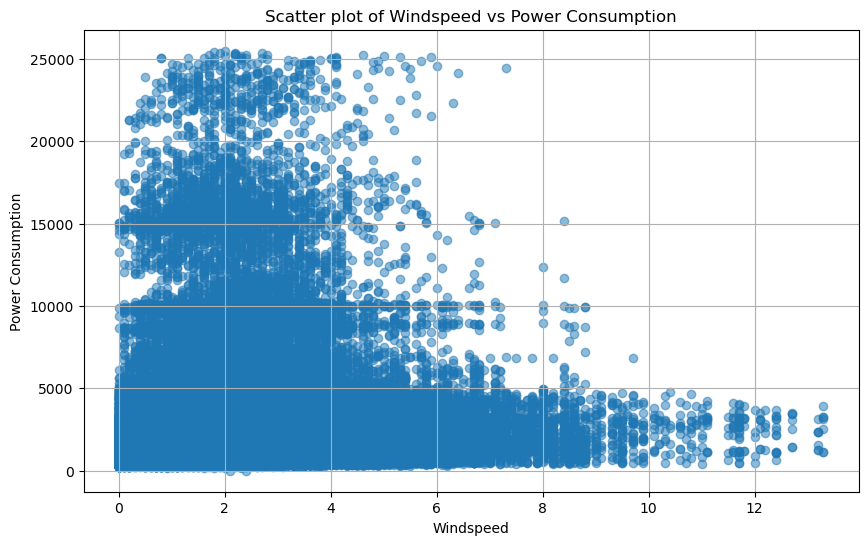

In [39]:
# 결측치가 있는 rainfall 값 필터링
windspeed_notna = train_ft[train_ft['windspeed'].notna()]

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.scatter(windspeed_notna['windspeed'], windspeed_notna['power_consumption'], alpha=0.5)
plt.title('Scatter plot of Windspeed vs Power Consumption')
plt.xlabel('Windspeed')
plt.ylabel('Power Consumption')
plt.grid(True)
plt.show()

### 3) humidity

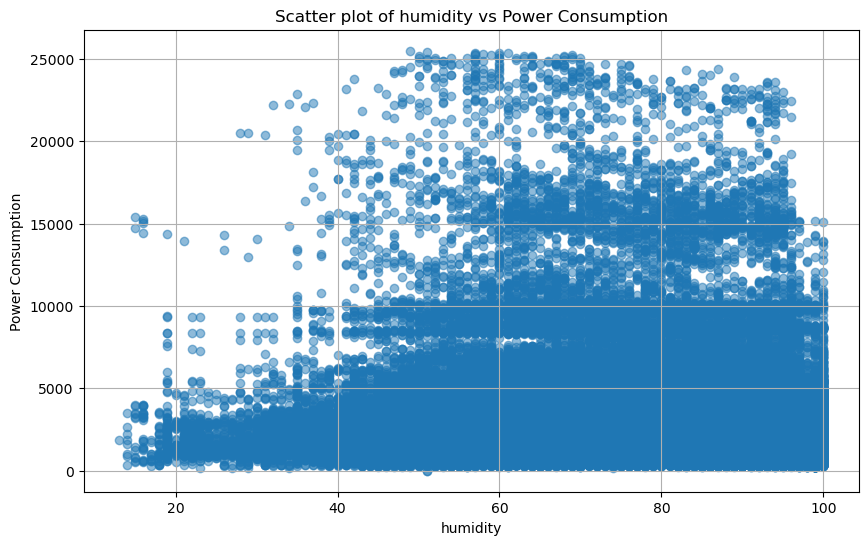

In [40]:
# 결측치가 있는 rainfall 값 필터링
humidity_notna = train_ft[train_ft['humidity'].notna()]

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.scatter(humidity_notna['humidity'], humidity_notna['power_consumption'], alpha=0.5)
plt.title('Scatter plot of humidity vs Power Consumption')
plt.xlabel('humidity')
plt.ylabel('Power Consumption')
plt.grid(True)
plt.show()

## datetime 처리

In [41]:
date = pd.to_datetime(train_ft['date_time'])
train_ft['hour'] = date.dt.hour
train_ft['day'] = date.dt.weekday
train_ft['month'] = date.dt.month
train_ft['week'] = date.dt.weekofyear

# EDA용
# train_df['date_time'] = pd.to_datetime(train_df['date_time'])

# # date time feature 생성
# train_df['hour'] = train_df['date_time'].dt.hour
# train_df['day'] = train_df['date_time'].dt.day
# train_df['month'] = train_df['date_time'].dt.month
# train_df['year'] = train_df['date_time'].dt.year
# train_df['week'] = train_df['date_time'].dt.weekofyear

In [42]:
date = pd.to_datetime(test_ft['date_time'])
test_ft['hour'] = date.dt.hour
test_ft['day'] = date.dt.weekday
test_ft['month'] = date.dt.month
test_ft['week'] = date.dt.weekofyear

# EDA용
# test_df['date_time'] = pd.to_datetime(test_df['date_time'])

# # date time feature 생성
# test_df['hour'] = test_df['date_time'].dt.hour
# test_df['day'] = test_df['date_time'].dt.day
# test_df['month'] = test_df['date_time'].dt.month
# test_df['year'] = test_df['date_time'].dt.year
# test_df['week'] = test_df['date_time'].dt.weekofyear

## power consumtion 분포

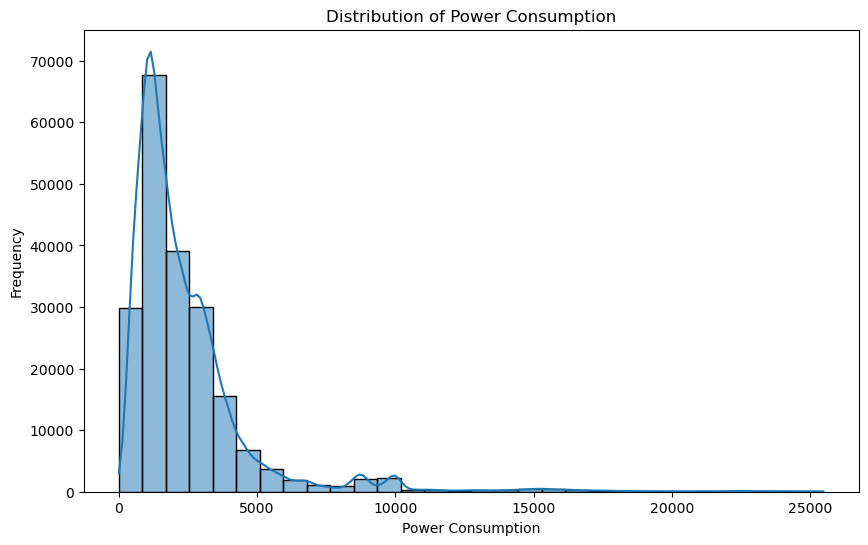

In [43]:
# histogram 생성
plt.figure(figsize=(10, 6))
sns.histplot(train_ft['power_consumption'], bins=30, kde=True)
plt.title('Distribution of Power Consumption')
plt.xlabel('Power Consumption')
plt.ylabel('Frequency')
plt.show()

## 소비 전력 평균 분포 시각화

- 낮 시간대에는 전력소모량 증가, 밤 시간대에는 전력 증가, 사람들이 일하는 시간에 증가
- 전체적으로 8월에 가까워질수록 전력 사용량이 증가 -> 에어컨 사용량 증가로 추정
- day of the year을 보면 중간중간 훅하고 떨어짐 -> 주말에 일 X

In [44]:
# 년기준 일 평균 소비전력
train_ft['day_of_year'] = date.dt.dayofyear
mean_power_by_day_of_year = train_ft.groupby('day_of_year')['power_consumption'].mean()

# 년기준 시간평균 소비전력
train_ft['hour_of_year'] = date.dt.hour + (date.dt.dayofyear - 1) * 24
mean_power_by_hour_of_year = train_ft.groupby('hour_of_year')['power_consumption'].mean()

# 년기준 월평균 소비전력
mean_power_by_month = train_ft.groupby('month')['power_consumption'].mean()

# 일기준 시간 평균 소비전력
mean_power_by_hour = train_ft.groupby('hour')['power_consumption'].mean()

# 월기준 시간 평균 소비전력
mean_power_by_day = train_ft.groupby('day')['power_consumption'].mean()

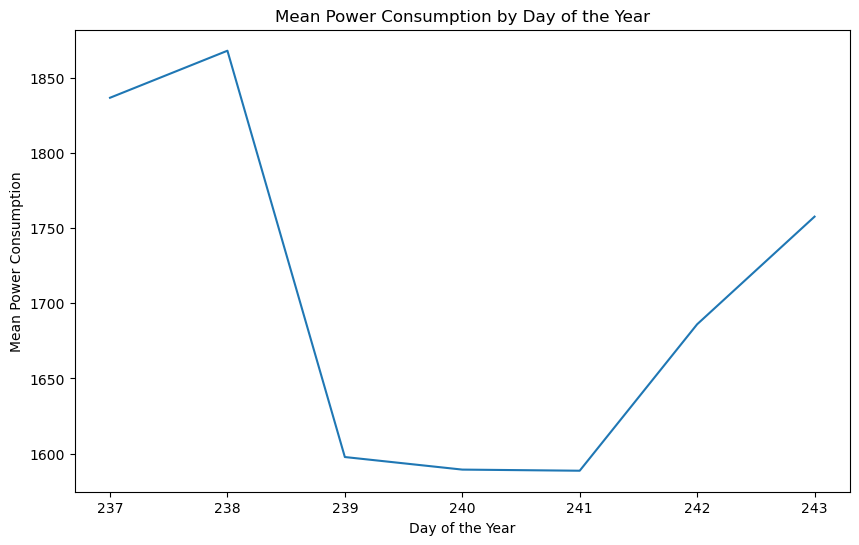

In [45]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=mean_power_by_day_of_year.index, y=mean_power_by_day_of_year.values)
plt.title('Mean Power Consumption by Day of the Year')
plt.xlabel('Day of the Year')
plt.ylabel('Mean Power Consumption')
plt.show()

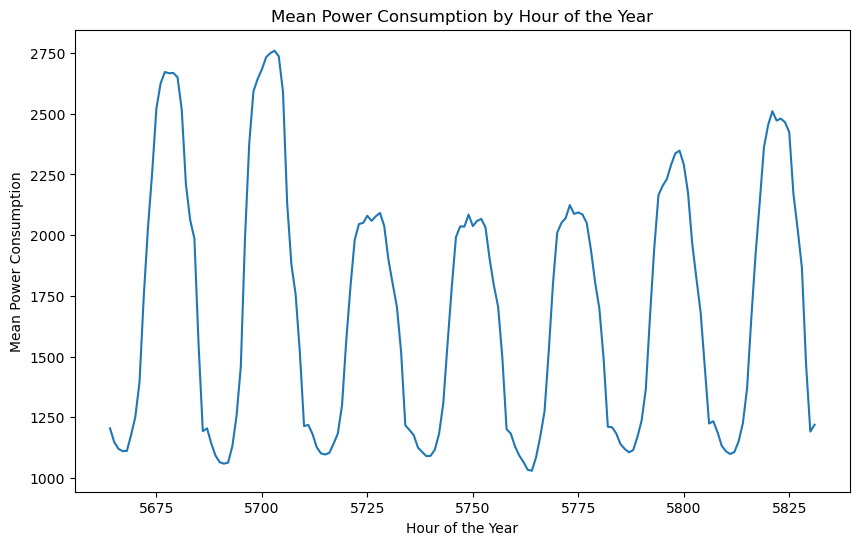

In [46]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=mean_power_by_hour_of_year.index, y=mean_power_by_hour_of_year.values)
plt.title('Mean Power Consumption by Hour of the Year')
plt.xlabel('Hour of the Year')
plt.ylabel('Mean Power Consumption')
plt.show()

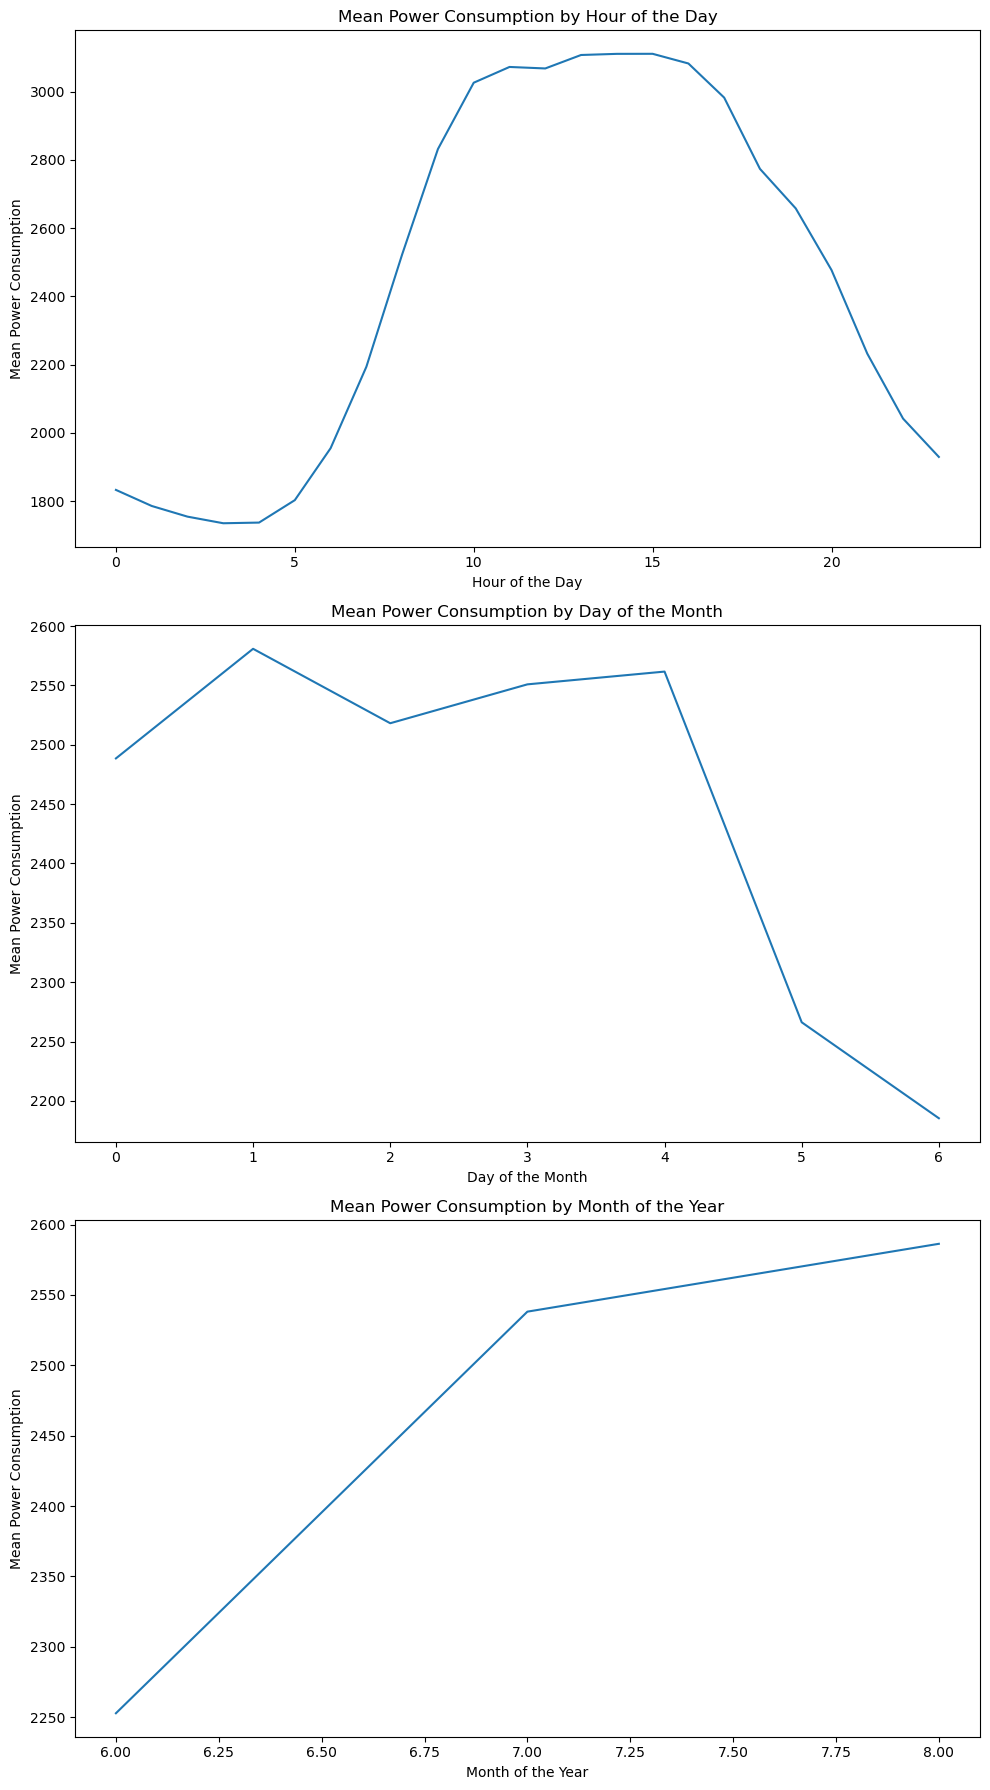

In [47]:
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Plot mean power consumption by hour of the day
sns.lineplot(x=mean_power_by_hour.index, y=mean_power_by_hour.values, ax=axs[0])
axs[0].set_title('Mean Power Consumption by Hour of the Day')
axs[0].set_xlabel('Hour of the Day')
axs[0].set_ylabel('Mean Power Consumption')

# Plot mean power consumption by day of the month
sns.lineplot(x=mean_power_by_day.index, y=mean_power_by_day.values, ax=axs[1])
axs[1].set_title('Mean Power Consumption by Day of the Month')
axs[1].set_xlabel('Day of the Month')
axs[1].set_ylabel('Mean Power Consumption')

# 년기준 월평균 소비전력
sns.lineplot(x=mean_power_by_month.index, y=mean_power_by_month.values, ax=axs[2])
axs[2].set_title('Mean Power Consumption by Month of the Year')
axs[2].set_xlabel('Month of the Year')
axs[2].set_ylabel('Mean Power Consumption')

plt.tight_layout()
plt.show()

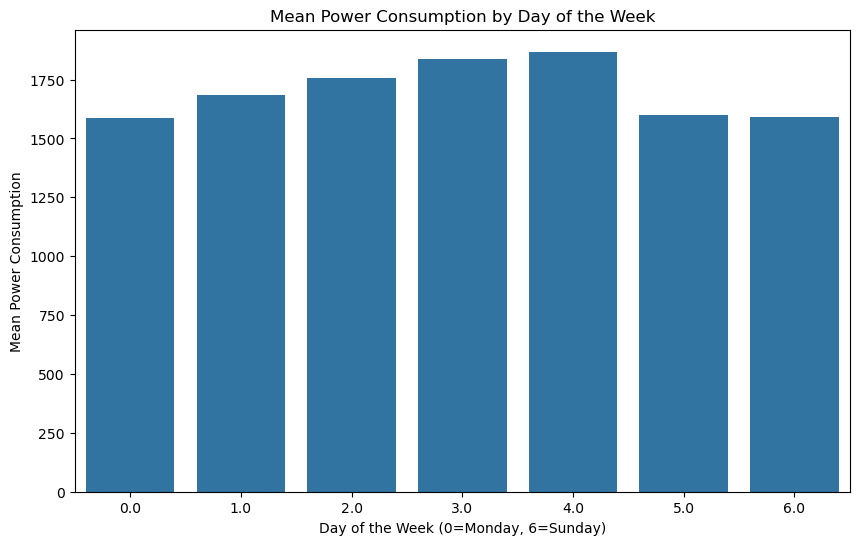

In [48]:
train_ft['day_of_week'] = date.dt.dayofweek

# 요일별 전력평균
mean_power_by_day_of_week = train_ft.groupby('day_of_week')['power_consumption'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=mean_power_by_day_of_week.index, y=mean_power_by_day_of_week.values)
plt.title('Mean Power Consumption by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Mean Power Consumption')
plt.show()

## building type별 데이터 소비 전력 평균 분포 시각화

In [49]:
train_df.head()

,building_number,date_time,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption
0,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


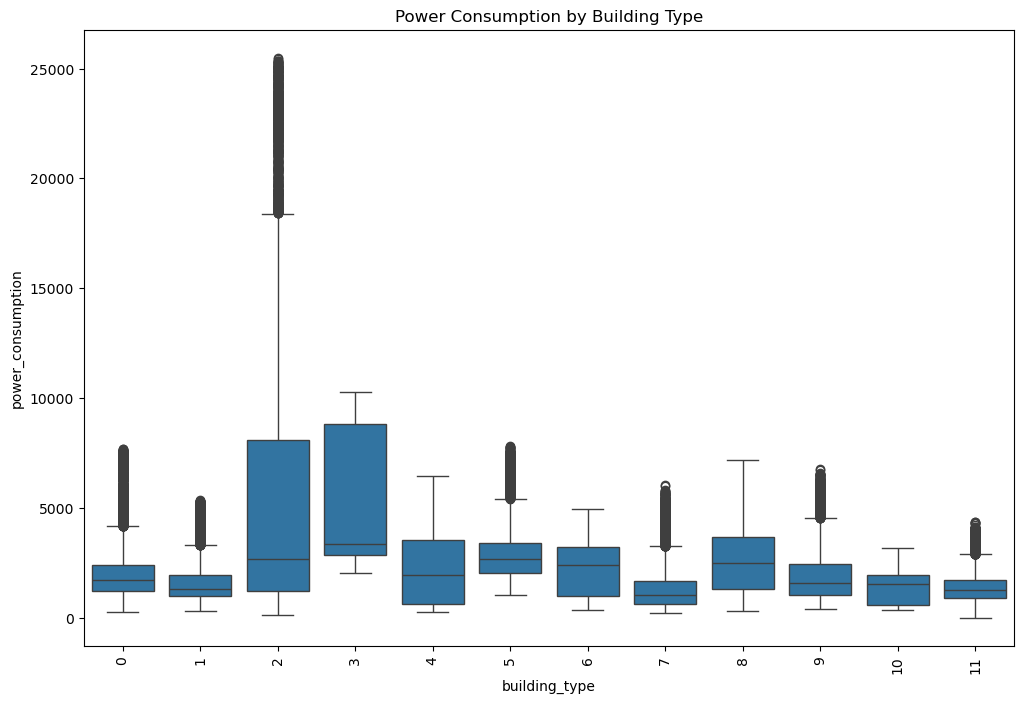

In [50]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='building_type', y='power_consumption', data=train_ft)
plt.title('Power Consumption by Building Type')
plt.xticks(rotation=90)
plt.show()

## hour of the day

- datacenter의 경우 요일 평균과, 시간 평균 모두 일정
- data center와 university에서 아주 많은 양의 전력 소모
- 대부분 낮시간에 전력을 많이 소모하지만 datacenter와 Apartment는 다른 양상을 보임
- 주말에는 전력 소비가 대체로 낮아지지만 상가나 아파트는 증가

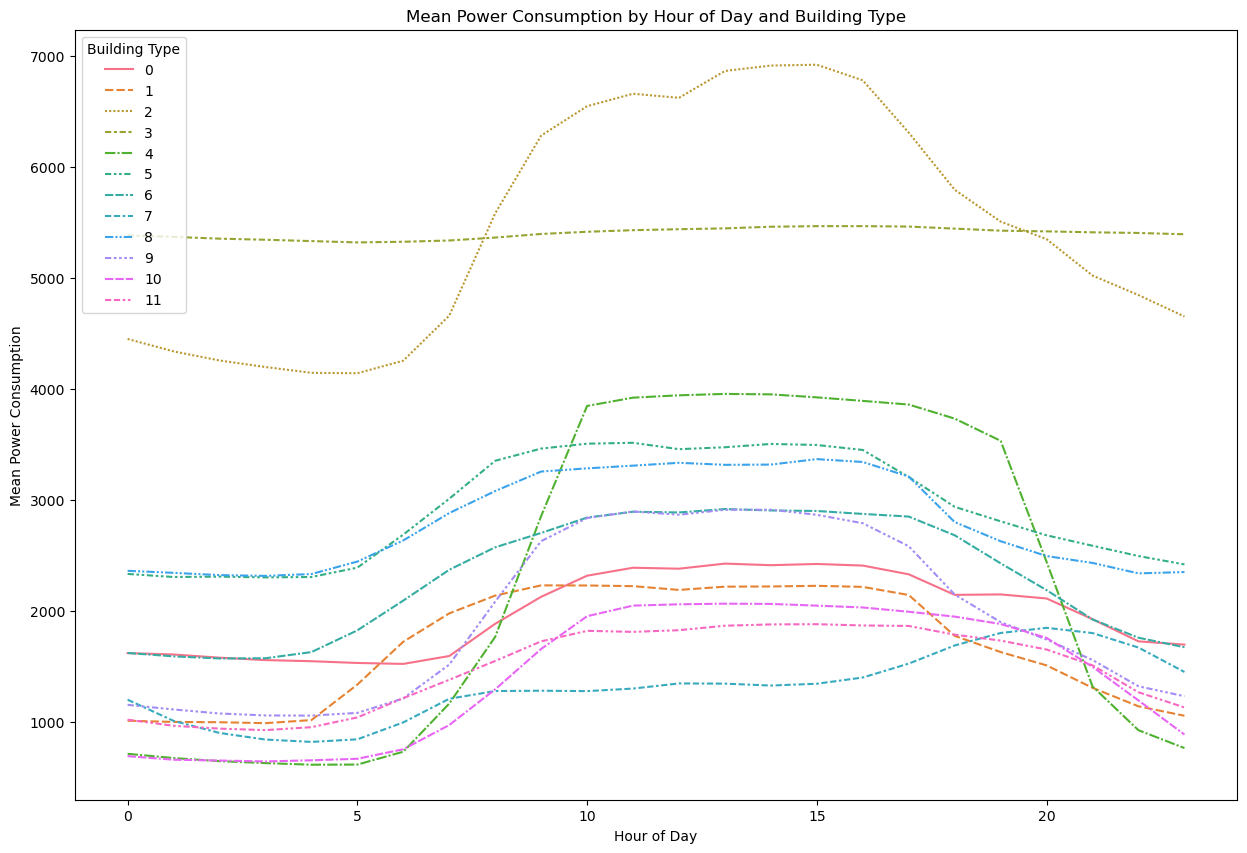

In [51]:
mean_power_by_hour_building = train_ft.groupby(['hour', 'building_type'])['power_consumption'].mean().reset_index()

pivot_df = mean_power_by_hour_building.pivot(index='hour', columns='building_type', values='power_consumption')

plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df)
plt.title('Mean Power Consumption by Hour of Day and Building Type')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Type')
plt.show()

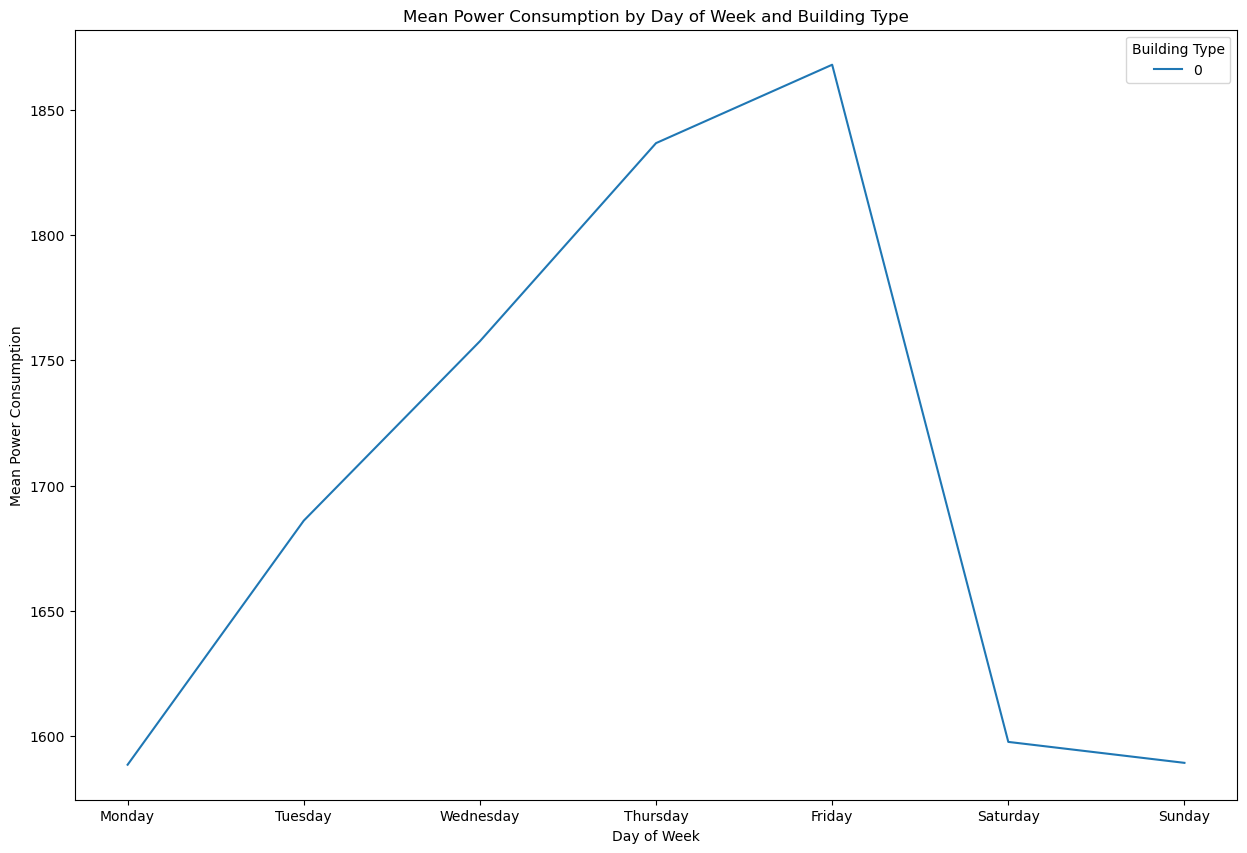

In [52]:
mean_power_by_day_building = train_ft.groupby(['day_of_week', 'building_type'])['power_consumption'].mean().reset_index()

pivot_df_day = mean_power_by_day_building.pivot(index='day_of_week', columns='building_type', values='power_consumption')

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_df_day.index = day_names

plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df_day)
plt.title('Mean Power Consumption by Day of Week and Building Type')
plt.xlabel('Day of Week')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Type')
plt.show()

## 상관계수 파악

### 1) 피어슨

In [53]:
train_corr_p = train_ft.corr(method='pearson')
print(train_corr_p)

                   building_number  temperature  rainfall  windspeed  \
building_number       1.000000e+00    -0.004505 -0.000248   0.021483   
temperature          -4.504794e-03     1.000000 -0.066500   0.220203   
rainfall             -2.477836e-04    -0.066500  1.000000   0.028729   
windspeed             2.148265e-02     0.220203  0.028729   1.000000   
humidity              2.298470e-02    -0.389854  0.271468  -0.219095   
power_consumption    -1.804737e-01     0.171190  0.015386   0.109954   
building_type         9.950194e-01    -0.000826  0.002150   0.028073   
total_area           -1.153222e-01    -0.003338  0.009215  -0.055012   
cooling_area         -1.161989e-01    -0.003055  0.009076  -0.053791   
hour                 -3.480358e-15     0.291429  0.038944   0.177099   
day                  -1.518670e-14     0.042881 -0.036235  -0.106587   
month                -2.790756e-14     0.427200  0.052792  -0.086350   
week                 -7.012767e-14     0.436925  0.069125  -0.04

Text(0.5, 1.0, 'Correlation between features')

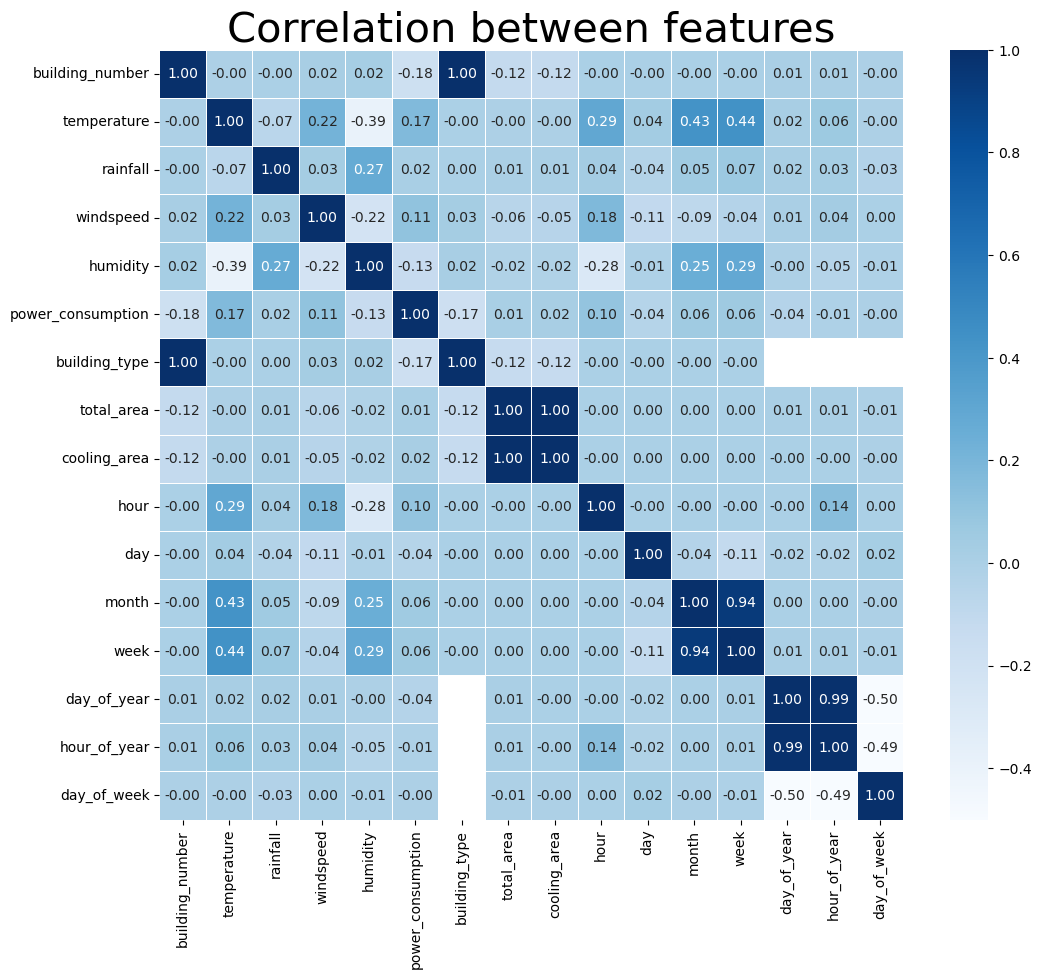

In [54]:
plt.figure(figsize=(12,10))
sns.heatmap(data = train_corr_p, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.title('Correlation between features', fontsize=30)

### 2) 스피어만

In [55]:
train_corr_s = train_ft.corr(method='spearman')
print(train_corr_s)

                   building_number  temperature  rainfall  windspeed  \
building_number           1.000000    -0.003607 -0.005957   0.017414   
temperature              -0.003607     1.000000 -0.285157   0.270387   
rainfall                 -0.005957    -0.285157  1.000000  -0.046059   
windspeed                 0.017414     0.270387 -0.046059   1.000000   
humidity                  0.025720    -0.438332  0.563096  -0.294064   
power_consumption        -0.162102     0.275223 -0.011883   0.219907   
building_type             0.995730    -0.000890 -0.004095   0.023544   
total_area               -0.081104     0.007420 -0.026646   0.012630   
cooling_area             -0.097403     0.007520 -0.027010   0.011350   
hour                      0.000000     0.298494  0.013017   0.209703   
day                       0.000000     0.019399 -0.044391  -0.079552   
month                     0.000000     0.416734  0.029313  -0.083169   
week                      0.000000     0.409282  0.064234  -0.04

Text(0.5, 1.0, 'Correlation between features')

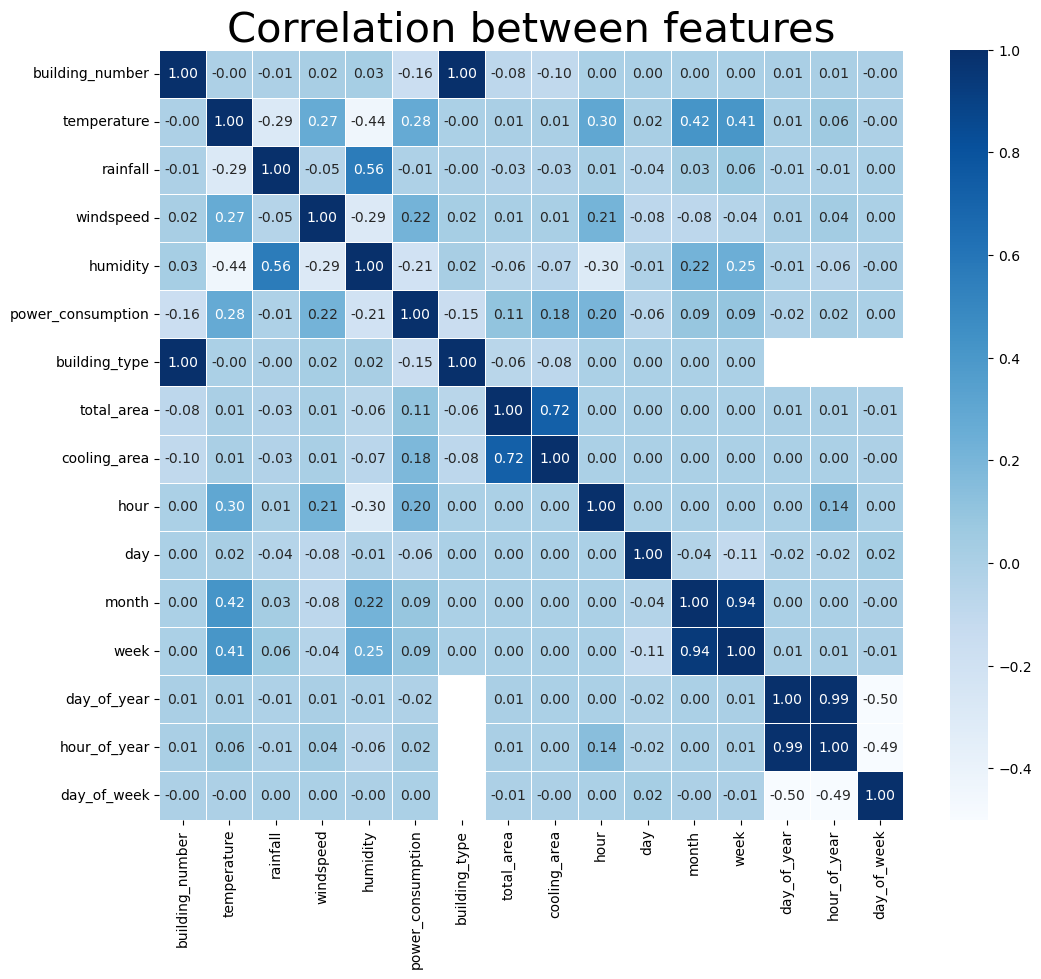

In [56]:
plt.figure(figsize=(12,10))
sns.heatmap(data = train_corr_s, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.title('Correlation between features', fontsize=30)

# 02. 데이터 전처리

## train_ft 결측치 채우기

In [57]:
train_ft.isna().sum()

building_number           0
date_time                 0
temperature               0
rainfall             160069
windspeed                19
humidity                  9
power_consumption         0
building_type             0
total_area                0
cooling_area              0
hour                      0
day                       0
month                     0
week                      0
day_of_year          187200
hour_of_year         187200
day_of_week          187200
dtype: int64

In [58]:
train_ft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204000 entries, 0 to 203999
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   building_number    204000 non-null  int64  
 1   date_time          204000 non-null  object 
 2   temperature        204000 non-null  float64
 3   rainfall           43931 non-null   float64
 4   windspeed          203981 non-null  float64
 5   humidity           203991 non-null  float64
 6   power_consumption  204000 non-null  float64
 7   building_type      204000 non-null  int64  
 8   total_area         204000 non-null  float64
 9   cooling_area       204000 non-null  float64
 10  hour               204000 non-null  int64  
 11  day                204000 non-null  int64  
 12  month              204000 non-null  int64  
 13  week               204000 non-null  int64  
 14  day_of_year        16800 non-null   float64
 15  hour_of_year       16800 non-null   float64
 16  da

In [59]:
test_ft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16800 entries, 0 to 16799
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   building_number  16800 non-null  int64  
 1   date_time        16800 non-null  object 
 2   temperature      16800 non-null  float64
 3   rainfall         16800 non-null  float64
 4   windspeed        16800 non-null  float64
 5   humidity         16800 non-null  int64  
 6   building_type    16800 non-null  int64  
 7   total_area       16800 non-null  float64
 8   cooling_area     16800 non-null  float64
 9   hour             16800 non-null  int64  
 10  day              16800 non-null  int64  
 11  month            16800 non-null  int64  
 12  week             16800 non-null  int64  
dtypes: float64(5), int64(7), object(1)
memory usage: 2.3+ MB


### 1) rainfall

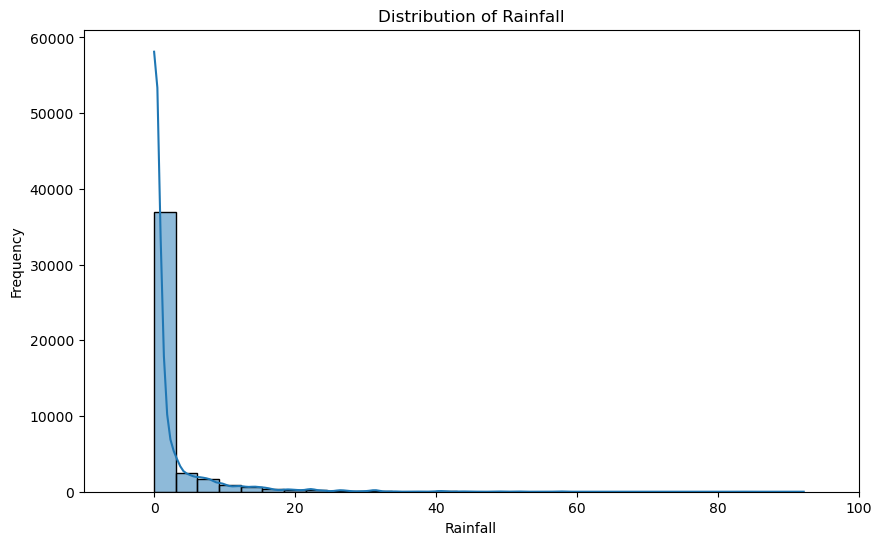

In [60]:
# histogram 생성
plt.figure(figsize=(10, 6))
sns.histplot(train_ft['rainfall'], bins=30, kde=True)
plt.title('Distribution of Rainfall')
plt.xlabel('Rainfall')
plt.ylabel('Frequency')
plt.xlim(-10, 100)
plt.show()

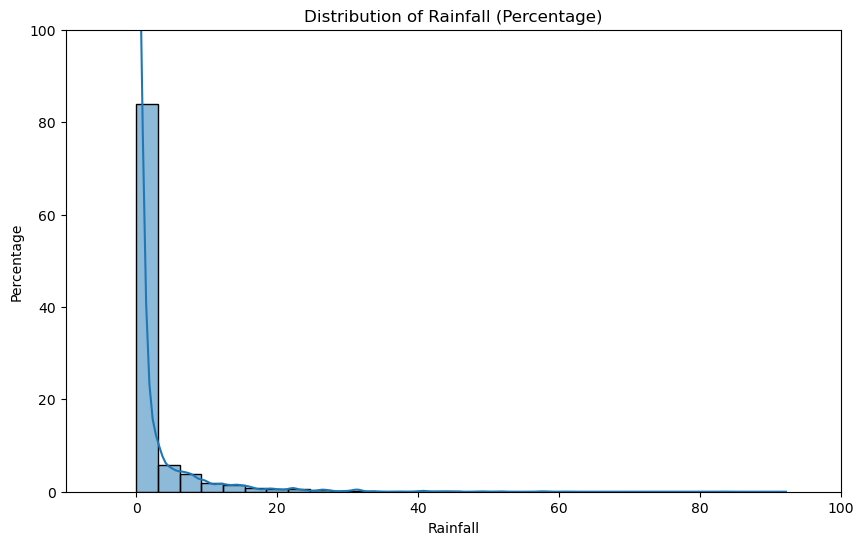

In [61]:
# 히스토그램 생성 (퍼센트 비율)
plt.figure(figsize=(10, 6))
sns.histplot(train_ft['rainfall'], bins=30, kde=True, stat='percent')
plt.title('Distribution of Rainfall (Percentage)')
plt.xlabel('Rainfall')
plt.ylabel('Percentage')
plt.xlim(-10, 100)
plt.ylim(0,100)
plt.show()

In [62]:
# 0으로 채우기
train_ft['rainfall'] = train_ft['rainfall'].fillna(0)

### 2) windspeed

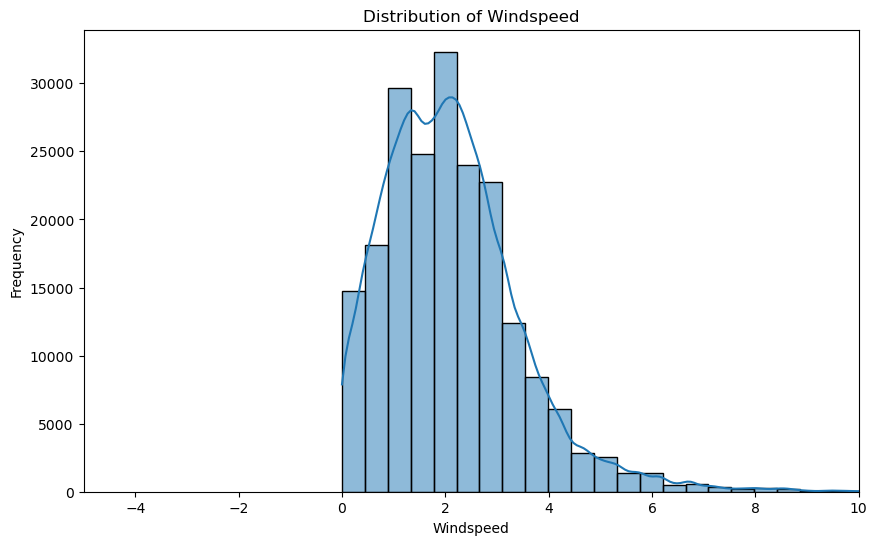

In [63]:
# histogram 생성
plt.figure(figsize=(10, 6))
sns.histplot(train_ft['windspeed'], bins=30, kde=True)
plt.title('Distribution of Windspeed')
plt.xlabel('Windspeed')
plt.ylabel('Frequency')
plt.xlim(-5, 10)
plt.show()

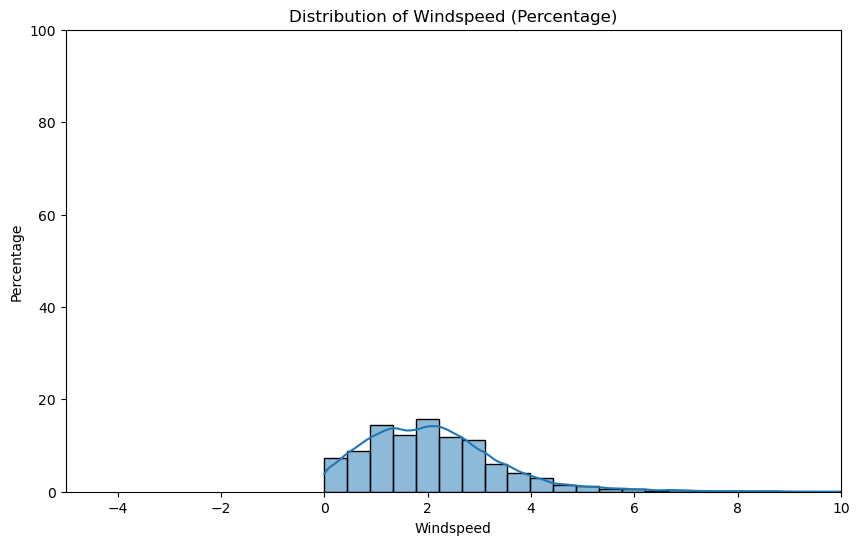

In [64]:
# 히스토그램 생성 (퍼센트 비율)
plt.figure(figsize=(10, 6))
sns.histplot(train_ft['windspeed'], bins=30, kde=True, stat='percent')
plt.title('Distribution of Windspeed (Percentage)')
plt.xlabel('Windspeed')
plt.ylabel('Percentage')
plt.xlim(-5, 10)
plt.ylim(0,100)
plt.show()

In [65]:
train_ft['windspeed'] = train_ft['windspeed'].fillna(method='ffill')

### 3) humidity

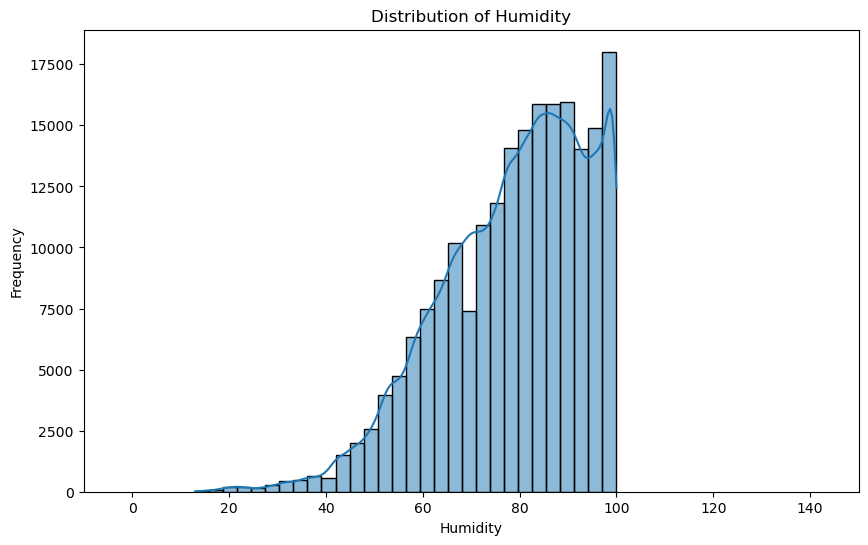

In [66]:
# histogram 생성
plt.figure(figsize=(10, 6))
sns.histplot(train_ft['humidity'], bins=30, kde=True)
plt.title('Distribution of Humidity')
plt.xlabel('Humidity')
plt.ylabel('Frequency')
plt.xlim(-10, 150)
plt.show()

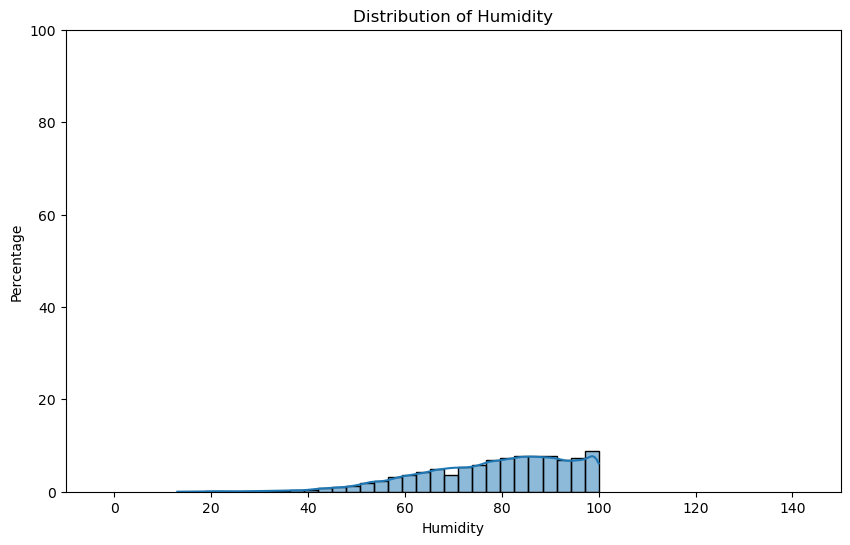

In [67]:
# 히스토그램 생성 (퍼센트 비율)
plt.figure(figsize=(10, 6))
sns.histplot(train_ft['humidity'], bins=30, kde=True, stat='percent')
plt.title('Distribution of Humidity')
plt.xlabel('Humidity')
plt.ylabel('Percentage')
plt.xlim(-10, 150)
plt.ylim(0,100)
plt.show()

In [68]:
train_ft['humidity'] = train_ft['humidity'].fillna(method='ffill')

### 4) 결측치 확인

In [69]:
train_ft.isna().sum()

building_number           0
date_time                 0
temperature               0
rainfall                  0
windspeed                 0
humidity                  0
power_consumption         0
building_type             0
total_area                0
cooling_area              0
hour                      0
day                       0
month                     0
week                      0
day_of_year          187200
hour_of_year         187200
day_of_week          187200
dtype: int64

## 이상치 제거 및 수정

### 1) IQR 이상치 제거 -> 귀찮았음요..죄송

In [70]:
# train_data = train_df['temperature']

# # 상자 그림(Box Plot) 그리기
# plt.figure(figsize=(10, 6))
# plt.boxplot(train_data, vert=False)
# plt.title('Box Plot of temperature')
# plt.xlabel('temperature')
# plt.show()

In [71]:
# level_1q = train_data.quantile(0.25)
# level_3q = train_data.quantile(0.75)
# IQR = level_3q - level_1q
# rev_range = 3  # 제거 범위 조절 변수
# dff = train_data[(train_data <= level_3q + (rev_range * IQR)) & (train_data >= level_1q - (rev_range * IQR))]
# dff = dff.reset_index(drop=True)

## 공휴일 더하기

In [72]:
train_ft['holiday'] = train_ft.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)
test_ft['holiday'] = train_ft.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)

In [73]:
train_ft['sin_time'] = np.sin(2*np.pi*train_ft.hour/24)
train_ft['cos_time'] = np.cos(2*np.pi*train_ft.hour/24)
test_ft['sin_time'] = np.sin(2*np.pi*test_ft.hour/24)
test_ft['cos_time'] = np.cos(2*np.pi*test_ft.hour/24)

## 불쾌지수

In [74]:
# train_ft['THI'] = 9/5*train_ft['temperature'] - 0.55*(1-train_ft['humidity']/100)*(9/5*train_ft['humidity']-26)+32
# test_ft['THI'] = 9/5*test_ft['temperature'] - 0.55*(1-test_ft['humidity']/100)*(9/5*test_ft['humidity']-26)+32

In [75]:
# train_ft['THI'] = pd.cut(train_ft['THI'], bins = [0, 68, 75, 80, 200], labels = [1,2,3,4])
# train_ft['THI'] = train_ft['THI'].astype(int)
# test_ft['THI'] = pd.cut(test_ft['THI'], bins = [0, 68, 75, 80, 200], labels = [1,2,3,4])
# test_ft['THI'] = test_ft['THI'].astype(int)

In [76]:
# def CDH(xs):
#     ys = []
#     for i in range(len(xs)):
#         if i < 11:
#             ys.append(np.sum(xs[:(i+1)]-26))
#         else:
#             ys.append(np.sum(xs[(i-11):(i+1)]-26))
#     return np.array(ys)

In [77]:
# cdhs = np.array([])
# for num in range(1,101,1):
#     temp = train_ft[train_ft['building_number'] == num]
#     cdh = CDH(temp['temperature'].values)
#     cdhs = np.concatenate([cdhs, cdh])
# train_ft['CDH'] = cdhs

In [78]:
# cdhs = np.array([])
# for num in range(1,101,1):
#     temp = test_ft[test_ft['building_number'] == num]
#     cdh = CDH(temp['temperature'].values)
#     cdhs = np.concatenate([cdhs, cdh])
# test_ft['CDH'] = cdhs

## 요일 시간 별 사용량

In [79]:
power_mean = pd.pivot_table(train_ft, values = 'power_consumption', index = ['building_number', 'hour', 'day','month'], aggfunc = np.mean).reset_index()

power_mean = power_mean.drop_duplicates(subset=['building_number', 'hour', 'day'], keep='first')

train_ft = train_ft.merge(power_mean[['building_number', 'hour', 'day', 'power_consumption']],
                          on=['building_number', 'hour', 'day'],
                          how='left',
                          suffixes=('', '_mean'))
train_ft.rename(columns={'power_consumption_mean': 'day_hour_mean'}, inplace=True)

test_ft = test_ft.merge(power_mean[['building_number', 'hour', 'day', 'power_consumption']],
                        on=['building_number', 'hour', 'day'],
                        how='left',
                        suffixes=('', '_mean'))
test_ft.rename(columns={'power_consumption': 'day_hour_mean'}, inplace=True)


In [80]:
power_mean = pd.pivot_table(train_ft, values = 'power_consumption', index = ['building_number', 'hour', 'day','month'], aggfunc = np.mean).reset_index()

power_mean = power_mean.drop_duplicates(subset=['building_number', 'hour', 'month'], keep='first')

train_ft = train_ft.merge(power_mean[['building_number', 'hour', 'month', 'power_consumption']],
                          on=['building_number', 'hour', 'month'],
                          how='left',
                          suffixes=('', '_mean'))
train_ft.rename(columns={'power_consumption_mean': 'month_hour_mean'}, inplace=True)

test_ft = test_ft.merge(power_mean[['building_number', 'hour', 'month', 'power_consumption']],
                        on=['building_number', 'hour', 'month'],
                        how='left',
                        suffixes=('', '_mean'))
test_ft.rename(columns={'power_consumption': 'month_hour_mean'}, inplace=True)


In [81]:
power_mean = pd.pivot_table(train_ft, values = 'power_consumption', index = ['building_number', 'hour'], aggfunc = np.mean).reset_index()
train_ft = train_ft.merge(power_mean[['building_number', 'hour', 'power_consumption']],
                          on=['building_number', 'hour'],
                          how='left',
                          suffixes=('', '_mean'))
train_ft.rename(columns={'power_consumption_mean': 'hour_mean'}, inplace=True)

test_ft = test_ft.merge(power_mean[['building_number', 'hour', 'power_consumption']],
                        on=['building_number', 'hour'],
                        how='left',
                        suffixes=('', '_mean'))
test_ft.rename(columns={'power_consumption': 'hour_mean'}, inplace=True)

In [82]:
power_std = pd.pivot_table(train_ft, values = 'power_consumption', index = ['building_number', 'hour'], aggfunc = np.std).reset_index()
train_ft = train_ft.merge(power_std[['building_number', 'hour', 'power_consumption']],
                          on=['building_number', 'hour'],
                          how='left',
                          suffixes=('', '_std'))
train_ft.rename(columns={'power_consumption_std': 'hour_std'}, inplace=True)

test_ft = test_ft.merge(power_std[['building_number', 'hour', 'power_consumption']],
                        on=['building_number', 'hour'],
                        how='left',
                        suffixes=('', '_std'))
test_ft.rename(columns={'power_consumption': 'hour_std'}, inplace=True)

In [83]:
power_std = pd.pivot_table(train_ft, values = 'power_consumption', index = ['building_number', 'hour', 'day'], aggfunc = np.std).reset_index()
train_ft = train_ft.merge(power_std[['building_number', 'hour', 'day', 'power_consumption']],
                          on=['building_number', 'hour', 'day'],
                          how='left',
                          suffixes=('', '_std'))
train_ft.rename(columns={'power_consumption_std': 'day_hour_std'}, inplace=True)

test_ft = test_ft.merge(power_std[['building_number', 'hour', 'day', 'power_consumption']],
                        on=['building_number', 'hour', 'day'],
                        how='left',
                        suffixes=('', '_std'))
test_ft.rename(columns={'power_consumption': 'day_hour_std'}, inplace=True)

In [84]:
power_median = pd.pivot_table(train_ft, values = 'power_consumption', index = ['building_number', 'hour', 'day'], aggfunc = np.median).reset_index()
train_ft = train_ft.merge(power_median[['building_number', 'hour', 'day', 'power_consumption']],
                          on=['building_number', 'hour', 'day'],
                          how='left',
                          suffixes=('', '_median'))
train_ft.rename(columns={'power_consumption_median': 'day_hour_median'}, inplace=True)

test_ft = test_ft.merge(power_median[['building_number', 'hour', 'day', 'power_consumption']],
                        on=['building_number', 'hour', 'day'],
                        how='left',
                        suffixes=('', '_median'))
test_ft.rename(columns={'power_consumption': 'day_hour_median'}, inplace=True)

In [85]:
train_ft.head()

,building_number,date_time,temperature,rainfall,windspeed,humidity,power_consumption,building_type,total_area,cooling_area,...,day_of_week,holiday,sin_time,cos_time,day_hour_mean,month_hour_mean,hour_mean,hour_std,day_hour_std,day_hour_median
0,1,20220601 00,18.6,0.0,0.9,42.0,1085.28,0,110634.0,39570.0,...,3.0,0,0.000000,1.000000,1174.656,1189.44,1706.318118,446.882767,517.982222,2094.72
1,1,20220601 01,18.0,0.0,1.1,45.0,1047.36,0,110634.0,39570.0,...,3.0,0,0.258819,0.965926,1101.600,1131.12,1622.620235,439.662704,500.769931,2015.52
2,1,20220601 02,17.7,0.0,1.5,45.0,974.88,0,110634.0,39570.0,...,3.0,0,0.500000,0.866025,1025.760,1063.56,1506.971294,412.071906,465.227458,1848.00
3,1,20220601 03,16.7,0.0,1.4,48.0,953.76,0,110634.0,39570.0,...,3.0,0,0.707107,0.707107,1015.584,1042.68,1437.365647,391.205981,436.601091,1764.00
4,1,20220601 04,18.4,0.0,2.8,43.0,986.40,0,110634.0,39570.0,...,3.0,0,0.866025,0.500000,1041.792,1075.44,1447.321412,381.099697,405.518091,1619.52


In [86]:
test_ft.head()

,building_number,date_time,temperature,rainfall,windspeed,humidity,building_type,total_area,cooling_area,hour,...,week,holiday,sin_time,cos_time,day_hour_mean,month_hour_mean,hour_mean,hour_std,day_hour_std,day_hour_median
0,1,20220825 00,23.5,0.0,2.2,72,0,110634.0,39570.0,0,...,34,0,0.000000,1.000000,1135.584,2237.04,1706.318118,446.882767,446.984913,1847.28
1,1,20220825 01,23.0,0.0,0.9,72,0,110634.0,39570.0,1,...,34,0,0.258819,0.965926,1054.848,2165.64,1622.620235,439.662704,449.091398,1772.40
2,1,20220825 02,22.7,0.0,1.5,75,0,110634.0,39570.0,2,...,34,0,0.500000,0.866025,975.648,2035.92,1506.971294,412.071906,415.453568,1624.80
3,1,20220825 03,22.1,0.0,1.3,78,0,110634.0,39570.0,3,...,34,0,0.707107,0.707107,956.736,1954.56,1437.365647,391.205981,378.117772,1557.84
4,1,20220825 04,21.8,0.0,1.0,77,0,110634.0,39570.0,4,...,34,0,0.866025,0.500000,984.768,1960.56,1447.321412,381.099697,360.348483,1561.68


In [87]:
train_ft = train_ft.drop(columns=['holiday', 'building_type', 'rainfall', 'windspeed','power_consumption'])
test_ft = test_ft.drop(columns=['holiday', 'building_type', 'rainfall', 'windspeed'])

In [88]:
# cols = ['building_number', 'temperature', 'humidity', 'hour', 'day', 'month', 'week', 'total_area',
#         'cooling_area', 'sin_time', 'cos_time', 'THI', 'CDH', 'day_hour_mean', 'month_hour_mean','hour_mean',
#         'hour_std','day_hour_std', 'day_hour_median']


cols = ['building_number', 'temperature', 'humidity', 'hour', 'day', 'month', 'week', 'total_area',
        'cooling_area', 'sin_time', 'cos_time', 'day_hour_mean', 'month_hour_mean','hour_mean',
        'hour_std','day_hour_std', 'day_hour_median']

In [89]:
train_ft= train_ft[cols]
test_ft = test_ft[cols]

In [90]:
train_ft['power_consumption'] = train_df['power_consumption']

## 클러스터링

In [91]:
train_ft['holiday'] = train_ft.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)
test_ft['holiday'] = train_ft.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)

In [92]:
# 평일 시간당 소비전력
weekday_mean = train_ft[train_ft.holiday==0].pivot_table(values='power_consumption', index=train_ft.building_number, columns='hour', aggfunc='first')

In [93]:
# 주말 시간당 소비전력
weekend_mean = train_ft[train_ft.holiday==1].pivot_table(values='power_consumption', index=train_ft.building_number, columns='hour', aggfunc='first')

In [94]:
tmp = pd.merge(weekday_mean,weekend_mean,how='left',on = 'building_number')
tmp

hour,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,14_y,15_y,16_y,17_y,18_y,19_y,20_y,21_y,22_y,23_y
building_number,,,,,,,,,,,,,,,,,,,,,
1,1085.28,1047.36,974.88,953.76,986.40,1087.20,1314.72,1684.80,1976.16,2289.12,...,3210.24,3153.60,3035.52,2726.40,2315.04,2229.60,2069.76,1733.76,1414.08,1191.84
2,1170.36,1146.96,1115.28,1107.00,1069.92,1075.32,1116.36,1254.24,887.40,1035.00,...,2245.68,2316.60,2528.28,2201.04,2028.60,1636.56,1380.96,1109.52,811.44,1268.64
3,926.28,884.52,882.36,867.24,880.92,808.56,786.24,809.64,818.64,882.36,...,1596.96,1791.72,1875.60,1746.00,1794.24,2265.48,2087.28,1052.64,972.72,912.60
4,740.16,671.04,619.20,626.40,626.22,630.36,752.04,829.44,957.60,1093.14,...,1237.50,1226.52,1172.70,1064.88,959.04,875.88,816.12,755.10,708.48,656.28
5,1304.64,1308.24,1302.48,1295.28,1316.88,1398.96,1492.56,1535.04,1548.72,1560.96,...,5785.92,5768.64,5553.36,5284.80,2644.56,1645.92,1538.64,1463.04,1404.00,1416.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1576.68,1558.68,1413.36,1483.92,1438.56,1503.84,1738.80,2073.36,2263.80,2621.04,...,3095.16,3043.80,3042.36,2958.84,2883.48,2780.04,2729.28,2525.88,2098.44,1848.72
97,774.36,553.86,558.90,559.44,559.62,582.48,640.26,903.78,855.18,907.56,...,1486.44,1469.88,1471.50,1340.46,1215.90,1180.98,1275.30,1128.42,975.96,895.14
98,533.52,516.78,509.40,479.70,541.98,712.08,947.88,1004.58,1069.02,1133.64,...,1298.16,1296.72,1273.32,1298.70,1238.22,1139.58,1093.68,979.20,783.00,654.30


In [95]:
kmeans= KMeans(n_clusters=5,random_state=SEED,n_init='auto')
kmeans.fit(tmp)

KMeans(n_clusters=5, n_init='auto', random_state=42)

In [96]:
def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

reset_seeds(SEED)

In [97]:
cluster_ = kmeans.predict(tmp)

In [98]:
tmp['cluster'] = cluster_

In [99]:
train_ft = train_ft.merge(tmp.cluster,how='left',on='building_number')
test_ft = test_ft.merge(tmp.cluster,how='left',on='building_number')

In [100]:
train_ft = train_ft.drop(columns=['holiday'])
test_ft = test_ft.drop(columns=['holiday'])

In [101]:
power_mean = pd.pivot_table(train_ft, values = 'power_consumption', index = ['cluster', 'hour', 'day','month'], aggfunc = np.mean).reset_index()

power_mean = power_mean.drop_duplicates(subset=['cluster', 'hour', 'day'], keep='first')

train_ft = train_ft.merge(power_mean[['cluster', 'hour', 'day', 'power_consumption']],
                          on=['cluster', 'hour', 'day'],
                          how='left',
                          suffixes=('', '_mean'))
train_ft.rename(columns={'power_consumption_mean': 'cluster_day_hour_mean'}, inplace=True)

test_ft = test_ft.merge(power_mean[['cluster', 'hour', 'day', 'power_consumption']],
                        on=['cluster', 'hour', 'day'],
                        how='left',
                        suffixes=('', '_mean'))
test_ft.rename(columns={'power_consumption': 'cluster_day_hour_mean'}, inplace=True)

In [102]:
display(train_ft)
display(test_ft)

,building_number,temperature,humidity,hour,day,month,week,total_area,cooling_area,sin_time,cos_time,day_hour_mean,month_hour_mean,hour_mean,hour_std,day_hour_std,day_hour_median,power_consumption,cluster,cluster_day_hour_mean
0,1,18.6,42.0,0,2,6,22,110634.00,39570.00,0.000000,1.000000,1174.656,1189.44,1706.318118,446.882767,517.982222,2094.72,1085.28,0,2005.185000
1,1,18.0,45.0,1,2,6,22,110634.00,39570.00,0.258819,0.965926,1101.600,1131.12,1622.620235,439.662704,500.769931,2015.52,1047.36,0,1952.292000
2,1,17.7,45.0,2,2,6,22,110634.00,39570.00,0.500000,0.866025,1025.760,1063.56,1506.971294,412.071906,465.227458,1848.00,974.88,0,1918.248500
3,1,16.7,48.0,3,2,6,22,110634.00,39570.00,0.707107,0.707107,1015.584,1042.68,1437.365647,391.205981,436.601091,1764.00,953.76,0,1894.579500
4,1,18.4,43.0,4,2,6,22,110634.00,39570.00,0.866025,0.500000,1041.792,1075.44,1447.321412,381.099697,405.518091,1619.52,986.40,0,1901.786500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,23.1,86.0,19,2,8,34,57497.84,40035.23,-0.965926,0.258819,832.752,1168.20,1010.462118,161.399578,163.825489,1017.12,881.04,4,1424.581127
203996,100,22.4,86.0,20,2,8,34,57497.84,40035.23,-0.866025,0.500000,773.040,1026.00,928.125176,137.566008,153.076049,874.32,798.96,4,1353.478945
203997,100,21.3,92.0,21,2,8,34,57497.84,40035.23,-0.707107,0.707107,686.784,934.68,830.032941,128.300189,143.415686,781.20,825.12,4,1228.707309
203998,100,21.0,94.0,22,2,8,34,57497.84,40035.23,-0.500000,0.866025,584.736,815.52,723.100235,112.464079,105.147190,657.12,640.08,4,1073.485988


,building_number,temperature,humidity,hour,day,month,week,total_area,cooling_area,sin_time,cos_time,day_hour_mean,month_hour_mean,hour_mean,hour_std,day_hour_std,day_hour_median,cluster,cluster_day_hour_mean
0,1,23.5,72,0,3,8,34,110634.00,39570.00,0.000000,1.000000,1135.584,2237.04,1706.318118,446.882767,446.984913,1847.28,0,2011.061500
1,1,23.0,72,1,3,8,34,110634.00,39570.00,0.258819,0.965926,1054.848,2165.64,1622.620235,439.662704,449.091398,1772.40,0,1972.697000
2,1,22.7,75,2,3,8,34,110634.00,39570.00,0.500000,0.866025,975.648,2035.92,1506.971294,412.071906,415.453568,1624.80,0,1943.292000
3,1,22.1,78,3,3,8,34,110634.00,39570.00,0.707107,0.707107,956.736,1954.56,1437.365647,391.205981,378.117772,1557.84,0,1925.145000
4,1,21.8,77,4,3,8,34,110634.00,39570.00,0.866025,0.500000,984.768,1960.56,1447.321412,381.099697,360.348483,1561.68,0,1936.258500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,100,22.5,84,19,2,8,35,57497.84,40035.23,-0.965926,0.258819,832.752,1168.20,1010.462118,161.399578,163.825489,1017.12,4,1424.581127
16796,100,20.7,95,20,2,8,35,57497.84,40035.23,-0.866025,0.500000,773.040,1026.00,928.125176,137.566008,153.076049,874.32,4,1353.478945
16797,100,20.2,98,21,2,8,35,57497.84,40035.23,-0.707107,0.707107,686.784,934.68,830.032941,128.300189,143.415686,781.20,4,1228.707309
16798,100,20.1,97,22,2,8,35,57497.84,40035.23,-0.500000,0.866025,584.736,815.52,723.100235,112.464079,105.147190,657.12,4,1073.485988


In [103]:
train_ft=train_ft.drop(columns=['power_consumption'])

## 이동평균

In [104]:
# 7일 x 24시간 = 168시간
window_size = 96

train_ft['four_day_moving_average_temp'] = train_ft.groupby('building_number')['temperature'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

train_ft['four_day_moving_average_hum'] = train_ft.groupby('building_number')['humidity'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

window_size = 168

train_ft['seven_day_moving_average_temp'] = train_ft.groupby('building_number')['temperature'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

train_ft['seven_day_moving_average_hum'] = train_ft.groupby('building_number')['humidity'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())


train_ft.head()

,building_number,temperature,humidity,hour,day,month,week,total_area,cooling_area,sin_time,...,hour_mean,hour_std,day_hour_std,day_hour_median,cluster,cluster_day_hour_mean,four_day_moving_average_temp,four_day_moving_average_hum,seven_day_moving_average_temp,seven_day_moving_average_hum
0,1,18.6,42.0,0,2,6,22,110634.0,39570.0,0.000000,...,1706.318118,446.882767,517.982222,2094.72,0,2005.1850,18.60,42.0,18.60,42.0
1,1,18.0,45.0,1,2,6,22,110634.0,39570.0,0.258819,...,1622.620235,439.662704,500.769931,2015.52,0,1952.2920,18.30,43.5,18.30,43.5
2,1,17.7,45.0,2,2,6,22,110634.0,39570.0,0.500000,...,1506.971294,412.071906,465.227458,1848.00,0,1918.2485,18.10,44.0,18.10,44.0
3,1,16.7,48.0,3,2,6,22,110634.0,39570.0,0.707107,...,1437.365647,391.205981,436.601091,1764.00,0,1894.5795,17.75,45.0,17.75,45.0
4,1,18.4,43.0,4,2,6,22,110634.0,39570.0,0.866025,...,1447.321412,381.099697,405.518091,1619.52,0,1901.7865,17.88,44.6,17.88,44.6


In [105]:
for i in range(1,101):
  test_ft = pd.concat([train_ft[train_ft['building_number']==i],test_ft],axis=0)

In [106]:
# 4일 x 24시간 = 168시간
window_size = 96

test_ft['four_day_moving_average_temp'] = test_ft.groupby('building_number')['temperature'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

test_ft['four_day_moving_average_hum'] = test_ft.groupby('building_number')['humidity'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

window_size = 168

test_ft['seven_day_moving_average_temp'] = test_ft.groupby('building_number')['temperature'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

test_ft['seven_day_moving_average_hum'] = test_ft.groupby('building_number')['humidity'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

test_ft.head()

,building_number,temperature,humidity,hour,day,month,week,total_area,cooling_area,sin_time,...,hour_mean,hour_std,day_hour_std,day_hour_median,cluster,cluster_day_hour_mean,four_day_moving_average_temp,four_day_moving_average_hum,seven_day_moving_average_temp,seven_day_moving_average_hum
201960,100,15.0,70.0,0,2,6,22,57497.84,40035.23,0.000000,...,450.982588,57.618897,67.693627,430.80,4,899.816000,15.000000,70.00,15.000000,70.00
201961,100,14.2,75.0,1,2,6,22,57497.84,40035.23,0.258819,...,404.450824,48.260651,60.788147,387.36,4,867.600073,14.600000,72.50,14.600000,72.50
201962,100,13.5,77.0,2,2,6,22,57497.84,40035.23,0.500000,...,381.910588,46.060484,59.132642,365.52,4,842.552400,14.233333,74.00,14.233333,74.00
201963,100,13.4,81.0,3,2,6,22,57497.84,40035.23,0.707107,...,372.900706,44.517603,57.770095,362.16,4,835.787570,14.025000,75.75,14.025000,75.75
201964,100,13.8,79.0,4,2,6,22,57497.84,40035.23,0.866025,...,369.554824,42.833213,54.814466,352.80,4,835.758655,13.980000,76.40,13.980000,76.40


In [107]:
test_ft = test_ft.iloc[-16800:]

In [108]:
display(train_ft)
display(test_ft)

,building_number,temperature,humidity,hour,day,month,week,total_area,cooling_area,sin_time,...,hour_mean,hour_std,day_hour_std,day_hour_median,cluster,cluster_day_hour_mean,four_day_moving_average_temp,four_day_moving_average_hum,seven_day_moving_average_temp,seven_day_moving_average_hum
0,1,18.6,42.0,0,2,6,22,110634.00,39570.00,0.000000,...,1706.318118,446.882767,517.982222,2094.72,0,2005.185000,18.600000,42.000000,18.600000,42.000000
1,1,18.0,45.0,1,2,6,22,110634.00,39570.00,0.258819,...,1622.620235,439.662704,500.769931,2015.52,0,1952.292000,18.300000,43.500000,18.300000,43.500000
2,1,17.7,45.0,2,2,6,22,110634.00,39570.00,0.500000,...,1506.971294,412.071906,465.227458,1848.00,0,1918.248500,18.100000,44.000000,18.100000,44.000000
3,1,16.7,48.0,3,2,6,22,110634.00,39570.00,0.707107,...,1437.365647,391.205981,436.601091,1764.00,0,1894.579500,17.750000,45.000000,17.750000,45.000000
4,1,18.4,43.0,4,2,6,22,110634.00,39570.00,0.866025,...,1447.321412,381.099697,405.518091,1619.52,0,1901.786500,17.880000,44.600000,17.880000,44.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,23.1,86.0,19,2,8,34,57497.84,40035.23,-0.965926,...,1010.462118,161.399578,163.825489,1017.12,4,1424.581127,25.161458,87.552083,25.341667,86.809524
203996,100,22.4,86.0,20,2,8,34,57497.84,40035.23,-0.866025,...,928.125176,137.566008,153.076049,874.32,4,1353.478945,25.127083,87.531250,25.327976,86.875000
203997,100,21.3,92.0,21,2,8,34,57497.84,40035.23,-0.707107,...,830.032941,128.300189,143.415686,781.20,4,1228.707309,25.094792,87.489583,25.321429,86.892857
203998,100,21.0,94.0,22,2,8,34,57497.84,40035.23,-0.500000,...,723.100235,112.464079,105.147190,657.12,4,1073.485988,25.063542,87.458333,25.311905,86.928571


,building_number,temperature,humidity,hour,day,month,week,total_area,cooling_area,sin_time,...,hour_mean,hour_std,day_hour_std,day_hour_median,cluster,cluster_day_hour_mean,four_day_moving_average_temp,four_day_moving_average_hum,seven_day_moving_average_temp,seven_day_moving_average_hum
0,1,23.5,72.0,0,3,8,34,110634.00,39570.00,0.000000,...,1706.318118,446.882767,446.984913,1847.28,0,2011.061500,26.292708,73.385417,26.369643,76.553571
1,1,23.0,72.0,1,3,8,34,110634.00,39570.00,0.258819,...,1622.620235,439.662704,449.091398,1772.40,0,1972.697000,26.253125,73.270833,26.367262,76.494048
2,1,22.7,75.0,2,3,8,34,110634.00,39570.00,0.500000,...,1506.971294,412.071906,415.453568,1624.80,0,1943.292000,26.211458,73.166667,26.364881,76.440476
3,1,22.1,78.0,3,3,8,34,110634.00,39570.00,0.707107,...,1437.365647,391.205981,378.117772,1557.84,0,1925.145000,26.167708,73.093750,26.358333,76.404762
4,1,21.8,77.0,4,3,8,34,110634.00,39570.00,0.866025,...,1447.321412,381.099697,360.348483,1561.68,0,1936.258500,26.129167,73.041667,26.352976,76.345238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,100,22.5,84.0,19,2,8,35,57497.84,40035.23,-0.965926,...,1010.462118,161.399578,163.825489,1017.12,4,1424.581127,20.070833,86.343750,20.854762,83.607143
16796,100,20.7,95.0,20,2,8,35,57497.84,40035.23,-0.866025,...,928.125176,137.566008,153.076049,874.32,4,1353.478945,20.080208,86.593750,20.844643,83.660714
16797,100,20.2,98.0,21,2,8,35,57497.84,40035.23,-0.707107,...,830.032941,128.300189,143.415686,781.20,4,1228.707309,20.108333,86.760417,20.838095,83.696429
16798,100,20.1,97.0,22,2,8,35,57497.84,40035.23,-0.500000,...,723.100235,112.464079,105.147190,657.12,4,1073.485988,20.141667,86.875000,20.832738,83.714286


In [109]:
cv= KFold(n_splits = 5,shuffle=True,random_state = SEED)

In [110]:
model_LGBM =  LGBMRegressor(random_state=SEED)

In [111]:
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred)*2)/(np.abs(true) + np.abs(pred))) * 100

cat_col = ['building_number','cluster','day','week']
def lgbm_smape(preds, train_data):
    '''
    Custom Evaluation Function for LGBM
    '''
    # labels = train_data.get_label()
    labels = train_data
    smape_val=SMAPE(labels,preds)
    return 'SMAPE', smape_val, False

In [112]:
train_ft2 = train_ft.copy()
test_ft2 = test_ft.copy()

In [113]:
train_ft = train_ft2[train_ft2.columns[:-2]]
test_ft = test_ft2[test_ft2.columns[:-2]]

In [114]:
# scores = cross_val_score(model_LGBM, train_ft, target, cv = cv ,scoring=make_scorer(SMAPE,greater_is_better=False),n_jobs = -1)
# print(f"LGBM : {-np.mean(scores)}")
# # {-np.mean(scores)}이 0에 가까울수록 모델의 예측 성능이 좋음을 나타내며, -200에 가까울수록 모델의 예측 성능이 나쁨

# 03. 학습

## LightGBM

In [ ]:
reset_seeds(SEED)
models = []
for i in tqdm(range(42,53)):
    print(f"###################[{i}]SEED################################")
    lgbm_params = {'random_state': i,
                   'n_estimators': 15000,
                   # 'objective' : weighted_mse(100),
                   'num_leaves': 8,
                   'min_child_samples': 12,
                   'learning_rate': 0.17010396907527026,
                   'colsample_bytree': 0.9605563464803123,
                   'reg_alpha': 0.1110993344544235,
                   'reg_lambda': 0.7948637803974561,
                   'verbose': -1
                  }
    LGBM_model = LGBMRegressor(**lgbm_params)

    scores = []
    for tri, vai in tqdm(cv.split(train_ft),total=5):
        
        # 학습데이터
        x_train = train_ft.iloc[tri]
        y_train = target.iloc[tri]

        # 검증데이터
        x_valid = train_ft.iloc[vai]
        y_valid = target.iloc[vai]

        LGBM_model.fit(x_train,y_train,eval_metric=lgbm_smape,categorical_feature=cat_col,
                       eval_set=(x_valid,y_valid))

        pred = LGBM_model.predict(x_valid)

        score = SMAPE(y_valid,pred)
        print(score)
        scores.append(score)
        models.append(LGBM_model)

    print('model : ', models)
    print('mean value : ', np.mean(scores))

  0%|          | 0/11 [00:00<?, ?it/s]

###################[42]SEED################################


  0%|          | 0/5 [00:00<?, ?it/s]

3.204005448563918
3.243717493383503
3.2372357357381856
3.18273111373564
3.1857560536123333
model :  [LGBMRegressor(colsample_bytree=0.9605563464803123,
              learning_rate=0.17010396907527026, min_child_samples=12,
              n_estimators=15000, num_leaves=8, random_state=42,
              reg_alpha=0.1110993344544235, reg_lambda=0.7948637803974561,
              verbose=-1), LGBMRegressor(colsample_bytree=0.9605563464803123,
              learning_rate=0.17010396907527026, min_child_samples=12,
              n_estimators=15000, num_leaves=8, random_state=42,
              reg_alpha=0.1110993344544235, reg_lambda=0.7948637803974561,
              verbose=-1), LGBMRegressor(colsample_bytree=0.9605563464803123,
              learning_rate=0.17010396907527026, min_child_samples=12,
              n_estimators=15000, num_leaves=8, random_state=42,
              reg_alpha=0.1110993344544235, reg_lambda=0.7948637803974561,
              verbose=-1), LGBMRegressor(colsample_bytree=0

  0%|          | 0/5 [00:00<?, ?it/s]

3.1990905803418226
3.20694584511405
3.2056441730666636
3.152376914560364
3.1854981400860995
model :  [LGBMRegressor(colsample_bytree=0.9605563464803123,
              learning_rate=0.17010396907527026, min_child_samples=12,
              n_estimators=15000, num_leaves=8, random_state=42,
              reg_alpha=0.1110993344544235, reg_lambda=0.7948637803974561,
              verbose=-1), LGBMRegressor(colsample_bytree=0.9605563464803123,
              learning_rate=0.17010396907527026, min_child_samples=12,
              n_estimators=15000, num_leaves=8, random_state=42,
              reg_alpha=0.1110993344544235, reg_lambda=0.7948637803974561,
              verbose=-1), LGBMRegressor(colsample_bytree=0.9605563464803123,
              learning_rate=0.17010396907527026, min_child_samples=12,
              n_estimators=15000, num_leaves=8, random_state=42,
              reg_alpha=0.1110993344544235, reg_lambda=0.7948637803974561,
              verbose=-1), LGBMRegressor(colsample_bytree=

  0%|          | 0/5 [00:00<?, ?it/s]

3.179741462827343
3.2270372466946506
3.207907887736387
3.1700533676777667
3.1577485490829464
model :  [LGBMRegressor(colsample_bytree=0.9605563464803123,
              learning_rate=0.17010396907527026, min_child_samples=12,
              n_estimators=15000, num_leaves=8, random_state=42,
              reg_alpha=0.1110993344544235, reg_lambda=0.7948637803974561,
              verbose=-1), LGBMRegressor(colsample_bytree=0.9605563464803123,
              learning_rate=0.17010396907527026, min_child_samples=12,
              n_estimators=15000, num_leaves=8, random_state=42,
              reg_alpha=0.1110993344544235, reg_lambda=0.7948637803974561,
              verbose=-1), LGBMRegressor(colsample_bytree=0.9605563464803123,
              learning_rate=0.17010396907527026, min_child_samples=12,
              n_estimators=15000, num_leaves=8, random_state=42,
              reg_alpha=0.1110993344544235, reg_lambda=0.7948637803974561,
              verbose=-1), LGBMRegressor(colsample_bytree

  0%|          | 0/5 [00:00<?, ?it/s]

3.18397564324049
3.229718495072135
3.224311063912589
3.194775898452811
3.165188042869772
model :  [LGBMRegressor(colsample_bytree=0.9605563464803123,
              learning_rate=0.17010396907527026, min_child_samples=12,
              n_estimators=15000, num_leaves=8, random_state=42,
              reg_alpha=0.1110993344544235, reg_lambda=0.7948637803974561,
              verbose=-1), LGBMRegressor(colsample_bytree=0.9605563464803123,
              learning_rate=0.17010396907527026, min_child_samples=12,
              n_estimators=15000, num_leaves=8, random_state=42,
              reg_alpha=0.1110993344544235, reg_lambda=0.7948637803974561,
              verbose=-1), LGBMRegressor(colsample_bytree=0.9605563464803123,
              learning_rate=0.17010396907527026, min_child_samples=12,
              n_estimators=15000, num_leaves=8, random_state=42,
              reg_alpha=0.1110993344544235, reg_lambda=0.7948637803974561,
              verbose=-1), LGBMRegressor(colsample_bytree=0.9

  0%|          | 0/5 [00:00<?, ?it/s]

3.1879037261119696
3.2290038677909285
3.2254991905353325
3.18077439927054
3.1652900579154464
model :  [LGBMRegressor(colsample_bytree=0.9605563464803123,
              learning_rate=0.17010396907527026, min_child_samples=12,
              n_estimators=15000, num_leaves=8, random_state=42,
              reg_alpha=0.1110993344544235, reg_lambda=0.7948637803974561,
              verbose=-1), LGBMRegressor(colsample_bytree=0.9605563464803123,
              learning_rate=0.17010396907527026, min_child_samples=12,
              n_estimators=15000, num_leaves=8, random_state=42,
              reg_alpha=0.1110993344544235, reg_lambda=0.7948637803974561,
              verbose=-1), LGBMRegressor(colsample_bytree=0.9605563464803123,
              learning_rate=0.17010396907527026, min_child_samples=12,
              n_estimators=15000, num_leaves=8, random_state=42,
              reg_alpha=0.1110993344544235, reg_lambda=0.7948637803974561,
              verbose=-1), LGBMRegressor(colsample_bytree

  0%|          | 0/5 [00:00<?, ?it/s]

3.204240905495009
3.2261861220311583
3.2151596559726694
3.189495786990435
3.182041731182338
model :  [LGBMRegressor(colsample_bytree=0.9605563464803123,
              learning_rate=0.17010396907527026, min_child_samples=12,
              n_estimators=15000, num_leaves=8, random_state=42,
              reg_alpha=0.1110993344544235, reg_lambda=0.7948637803974561,
              verbose=-1), LGBMRegressor(colsample_bytree=0.9605563464803123,
              learning_rate=0.17010396907527026, min_child_samples=12,
              n_estimators=15000, num_leaves=8, random_state=42,
              reg_alpha=0.1110993344544235, reg_lambda=0.7948637803974561,
              verbose=-1), LGBMRegressor(colsample_bytree=0.9605563464803123,
              learning_rate=0.17010396907527026, min_child_samples=12,
              n_estimators=15000, num_leaves=8, random_state=42,
              reg_alpha=0.1110993344544235, reg_lambda=0.7948637803974561,
              verbose=-1), LGBMRegressor(colsample_bytree=

  0%|          | 0/5 [00:00<?, ?it/s]

3.193884526285761
3.2236971221915813
3.220495320467811
3.203293887410822
3.171242727752825
model :  [LGBMRegressor(colsample_bytree=0.9605563464803123,
              learning_rate=0.17010396907527026, min_child_samples=12,
              n_estimators=15000, num_leaves=8, random_state=42,
              reg_alpha=0.1110993344544235, reg_lambda=0.7948637803974561,
              verbose=-1), LGBMRegressor(colsample_bytree=0.9605563464803123,
              learning_rate=0.17010396907527026, min_child_samples=12,
              n_estimators=15000, num_leaves=8, random_state=42,
              reg_alpha=0.1110993344544235, reg_lambda=0.7948637803974561,
              verbose=-1), LGBMRegressor(colsample_bytree=0.9605563464803123,
              learning_rate=0.17010396907527026, min_child_samples=12,
              n_estimators=15000, num_leaves=8, random_state=42,
              reg_alpha=0.1110993344544235, reg_lambda=0.7948637803974561,
              verbose=-1), LGBMRegressor(colsample_bytree=0

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
pred_list = []
for model in tqdm(models):
    pred = model.predict(test_ft)
    pred_list.append(pred)

pred = np.mean(pred_list,axis=0)

In [ ]:
pred.shape

In [ ]:
submission = pd.read_csv(f'{DATA_PATH}sample_submission.csv')
submission

In [ ]:
submission['answer'] = pred
submission

In [ ]:
submission.to_csv(f'{DATA_PATH}result_pre00_lgbm.csv', index=False)